In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from pamda import pamda
import math
from collections import defaultdict
from scipy.optimize import curve_fit
import numpy as np

In [2]:
algorithms = {
    "bmssp_constant_degree_solve_time_ms": {"label": "BMSSP (Constant Degree)", "cmap": cm.Blues},
    "pure_python_sc_dijkstra_constant_degree_time_ms": {"label": "SC Dijkstra (Constant Degree)", "cmap": cm.Reds},
    "bmssp_solve_time_ms": {"label": "BMSSP", "cmap": cm.cividis},
    "sc_dijkstra_time_ms": {"label": "SC Dijkstra", "cmap": cm.viridis},
    "pure_python_sc_dijkstra_time_ms": {"label": "Pure Python SC Dijkstra", "cmap": cm.Oranges},
    "pure_python_heapdict_sc_dijkstra_time_ms": {"label": "Pure Python SC Dijkstra (HeapDict)", "cmap": cm.RdBu},
    "vanilla_dijkstra_time_ms": {"label": "Vanilla Dijkstra", "cmap": cm.Greens},
    "nx_dijkstra_time_ms": {"label": "NetworkX Dijkstra", "cmap": cm.Purples},
    "ig_dijkstra_time_ms": {"label": "iGraph Dijkstra", "cmap": cm.Greys}
}

algorithms_no_vanilla = {k:v for k,v in algorithms.items() if k != "vanilla_dijkstra_time_ms"}
algorithms_no_constant_degree = {k:v for k, v in algorithms.items() if 'constant_degree' not in k}
algorithms_faster = {k:v for k, v in algorithms.items() if 'vanilla' not in k and 'bmssp_constant_degree_solve_time_ms' not in k}

algorithms_gridscale = {k:v for k, v in algorithms.items() if k in [
    "bmssp_constant_degree_solve_time_ms",
    "pure_python_sc_dijkstra_constant_degree_time_ms",
    "bmssp_solve_time_ms",
    "sc_dijkstra_time_ms",
    "pure_python_sc_dijkstra_time_ms"
]}

algorithms_gridscale_no_constant_degree = {k:v for k, v in algorithms_gridscale.items() if 'constant_degree' not in k}

ITERATIONS_PER_CASE = 2

In [3]:
def make_aggregated_graph(data, title, scale="linear", algorithms=algorithms):
    # Structure: { algorithm: { nodes: [ (time, stdev) ] } }
    aggregated_data = {alg: defaultdict(list) for alg in algorithms}

    for row in data:
        try:
            nodes = int(row["graph_nodes"]) + int(row.get("graph_edges", 0))

            for alg in algorithms:
                time_val = float(row.get(alg, "nan"))
                stdev_val = float(row.get(alg.replace("_time_ms", "_stdev"), "nan"))

                if math.isnan(time_val) or math.isnan(stdev_val):
                    continue

                aggregated_data[alg][nodes].append((time_val, stdev_val))

        except Exception:
            continue  # Skip rows with invalid data

    # Plotting
    plt.figure(figsize=(14, 9))

    for alg_key, node_dict in aggregated_data.items():
        if not any(node_dict.values()):
            continue  # Skip algorithms with no data

        nodes = sorted(node_dict.keys())
        avg_times = []
        combined_stdevs = []

        for n in nodes:
            points = node_dict[n]
            if not points:
                continue

            times = [p[0] for p in points]
            stdevs = [p[1] for p in points]
            k = len(points)

            mean_time = sum(times) / k
            avg_times.append(mean_time)

            variance_components = [
                ITERATIONS_PER_CASE * (std**2 + (time - mean_time)**2)
                for time, std in zip(times, stdevs)
            ]
            combined_variance = sum(variance_components) / (k ** 2)
            combined_stdev = math.sqrt(combined_variance / ITERATIONS_PER_CASE)
            combined_stdevs.append(combined_stdev)

        label = algorithms[alg_key]["label"]
        color = algorithms[alg_key]["cmap"](0.8)  # Mid-dark shade

        # Plot line
        plt.plot(nodes, avg_times, label=label, color=color, linestyle='-', marker='o', linewidth=1.8)

        # Plot error band
        lower = [t - s for t, s in zip(avg_times, combined_stdevs)]
        upper = [t + s for t, s in zip(avg_times, combined_stdevs)]
        plt.fill_between(nodes, lower, upper, color=color, alpha=0.15)

    # Final plot formatting
    plt.title(title)
    plt.xlabel("Number of Nodes & Edges")
    plt.ylabel("Time (ms)")
    if scale == "log":
        plt.xscale("log")
        plt.yscale("log")
    elif scale == "linear":
        pass
    else:
        raise ValueError("Scale must be 'linear' or 'log'")
    plt.grid(True)
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

In [4]:
def make_graph(data, title, scale="linear", algorithms=algorithms):
    # Structure: { algorithm: { case_name: [ (nodes, time, stdev) ] } }
    grouped_data = {alg: {} for alg in algorithms}

    for row in data:
        try:
            case = row["case_name"]
            # nodes = int(row["graph_nodes"]) # Number of nodes
            nodes = int(row["graph_nodes"])+int(row.get("graph_edges", 0))  # Total nodes + edges for complexity
            for alg in algorithms:
                time = float(row.get(alg, "nan"))
                stdev = float(row.get(alg.replace("_time_ms", "_stdev"), "nan"))
                if time != float("nan") and stdev != float("nan"):
                    if case not in grouped_data[alg]:
                        grouped_data[alg][case] = []
                    grouped_data[alg][case].append((nodes, time, stdev))
        except:
            continue  # Skip rows with invalid data

    # Plotting
    plt.figure(figsize=(14, 9))

    for alg_key, case_dict in grouped_data.items():
        cases = list(case_dict.items())
        num_cases = len(cases)
        
        for i, (case_name, points) in enumerate(cases):
            if not points:
                continue
            # Sort by number of nodes
            points.sort(key=lambda x: x[0])
            nodes = [p[0] for p in points]
            times = [p[1] for p in points]
            stdevs = [p[2] for p in points]

            label = f"{algorithms[alg_key]['label']} ({case_name})"

            # Use a colormap to assign a different shade for each case
            cmap = algorithms[alg_key]["cmap"]
            color = cmap(0.4 + 0.6 * i / max(1, num_cases - 1))  # Shades from 0.4 to 1.0

            # Plot line
            plt.plot(nodes, times, label=label, color=color, linestyle='-', marker='o', linewidth=1.5)

            # # Plot error band
            lower = [t - s for t, s in zip(times, stdevs)]
            upper = [t + s for t, s in zip(times, stdevs)]
            plt.fill_between(nodes, lower, upper, color=color, alpha=0.1)

    # Final plot formatting
    plt.title(title)
    plt.xlabel("Number of Nodes & Edges")
    plt.ylabel("Time (ms)")

    if scale == "log":
        plt.xscale("log")
        plt.yscale("log")
    elif scale == "linear":
        pass
    else:
        raise ValueError("Scale must be 'linear' or 'log'")

    plt.grid(True)
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

In [5]:
def make_relative_performance_graph(data, title, baseline_alg, scale="linear", algorithms=algorithms):

    if baseline_alg not in algorithms:
        raise ValueError(f"Invalid baseline algorithm: {baseline_alg}")

    # Structure: { algorithm: { nodes: [ (time, stdev) ] } }
    aggregated_data = {alg: defaultdict(list) for alg in algorithms}

    for row in data:
        try:
            nodes = int(row["graph_nodes"]) + int(row.get("graph_edges", 0))

            for alg in algorithms:
                time_val = float(row.get(alg, "nan"))
                stdev_val = float(row.get(alg.replace("_time_ms", "_stdev"), "nan"))

                if math.isnan(time_val) or math.isnan(stdev_val):
                    continue

                aggregated_data[alg][nodes].append((time_val, stdev_val))

        except Exception:
            continue  # Skip invalid rows

    # Compute mean and stdev per node count
    mean_data = {}
    for alg, node_dict in aggregated_data.items():
        mean_data[alg] = {}
        for n, points in node_dict.items():
            times = [p[0] for p in points]
            stdevs = [p[1] for p in points]
            k = len(times)
            if k == 0:
                continue
            mean_time = sum(times) / k
            # Combined variance
            variance_components = [
                ITERATIONS_PER_CASE * (std**2 + (time - mean_time)**2)
                for time, std in zip(times, stdevs)
            ]
            combined_variance = sum(variance_components) / (k ** 2)
            combined_stdev = math.sqrt(combined_variance / ITERATIONS_PER_CASE)
            mean_data[alg][n] = (mean_time, combined_stdev)

    # Prepare the plot
    plt.figure(figsize=(14, 9))
    nodes = sorted(mean_data[baseline_alg].keys())

    for alg, props in algorithms.items():
        if alg == baseline_alg:
            continue

        x_vals = []
        multipliers = []
        multiplier_stdevs = []

        for n in nodes:
            if n not in mean_data[alg] or n not in mean_data[baseline_alg]:
                continue

            t_other, s_other = mean_data[alg][n]
            t_base, s_base = mean_data[baseline_alg][n]

            if t_base == 0:
                continue  # Avoid division by zero

            multiplier = t_other / t_base

            # Error propagation formula for ratio:
            # σ_r = r * sqrt((σ_a / a)^2 + (σ_b / b)^2)
            ratio_stdev = multiplier * math.sqrt(
                (s_other / t_other) ** 2 + (s_base / t_base) ** 2
            )

            x_vals.append(n)
            multipliers.append(multiplier)
            multiplier_stdevs.append(ratio_stdev)

        if not x_vals:
            continue

        color = props["cmap"](0.8)
        label = f"{props['label']} vs {algorithms[baseline_alg]['label']}"

        plt.plot(x_vals, multipliers, label=label, color=color, marker='o', linewidth=1.8)
        lower = [m - s for m, s in zip(multipliers, multiplier_stdevs)]
        upper = [m + s for m, s in zip(multipliers, multiplier_stdevs)]
        plt.fill_between(x_vals, lower, upper, color=color, alpha=0.15)

    plt.axhline(1.0, color='black', linestyle='--', linewidth=1, label="Baseline (×1)")
    plt.title(title)
    plt.xlabel("Number of Nodes & Edges")
    plt.ylabel(f"Runtime Multiplier vs {algorithms[baseline_alg]['label']}")
    if scale == "log":
        plt.xscale("log")
    elif scale == "linear":
        pass
    else:
        raise ValueError("Scale must be 'linear' or 'log'")
    plt.yscale("linear")
    plt.grid(True)
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

In [6]:
def power_law(x, a, b):
    return a * x ** b

def fit_curve(x, y):
    (a, b), _ = curve_fit(power_law, x, y, maxfev=10000)
    return (a, b)

def find_crossover(a1, b1, a2, b2):
    if b1 == b2:
        return None  # No crossover if slopes are equal
    out = (a2 / a1) ** (1 / (b1 - b2))
    return out if out > 1 else None

def plot_with_crossover(x, y1, y2, a1, b1, a2, b2, x_cross, title, algo_1_name, algo_2_name,scale="linear"):
    x_max = max(max(x), x_cross * 1.2 if x_cross else max(x) * 2)
    x_fit = np.linspace(min(x), x_max)
    
    y1_fit = power_law(x_fit, a1, b1)
    y2_fit = power_law(x_fit, a2, b2)

    plt.figure(figsize=(12, 8))
    plt.scatter(x, y1, label=algo_1_name, color="blue")
    plt.scatter(x, y2, label=algo_2_name, color="red")
    plt.plot(x_fit, y1_fit, label=f"{algo_1_name} Fit: {a1:.2e} * x^{b1:.2f}", color="blue", linestyle="--")
    plt.plot(x_fit, y2_fit, label=f"{algo_2_name} Fit: {a2:.2e} * x^{b2:.2f}", color="red", linestyle="--")

    if x_cross:
        y_cross = power_law(x_cross, a1, b1)
        plt.axvline(x_cross, color="green", linestyle=":", label=f"Crossover ≈ {x_cross:.2e} (nodes + edges)")
        plt.scatter([x_cross], [y_cross], color="green", zorder=5)

    plt.xlabel("Nodes + Edges")
    plt.ylabel("Runtime (ms)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if scale == "log":
        plt.xscale("log")
        plt.yscale("log")
    elif scale == "linear":
        pass
    else:
        raise ValueError("Scale must be 'linear' or 'log'")
    plt.tight_layout()
    plt.show()

In [7]:
data = pamda.read_csv(filename="./outputs/benchmark_time_tests.csv")
gridscale_data = [i for i in data if 'square' in i['graph_name'].lower()]

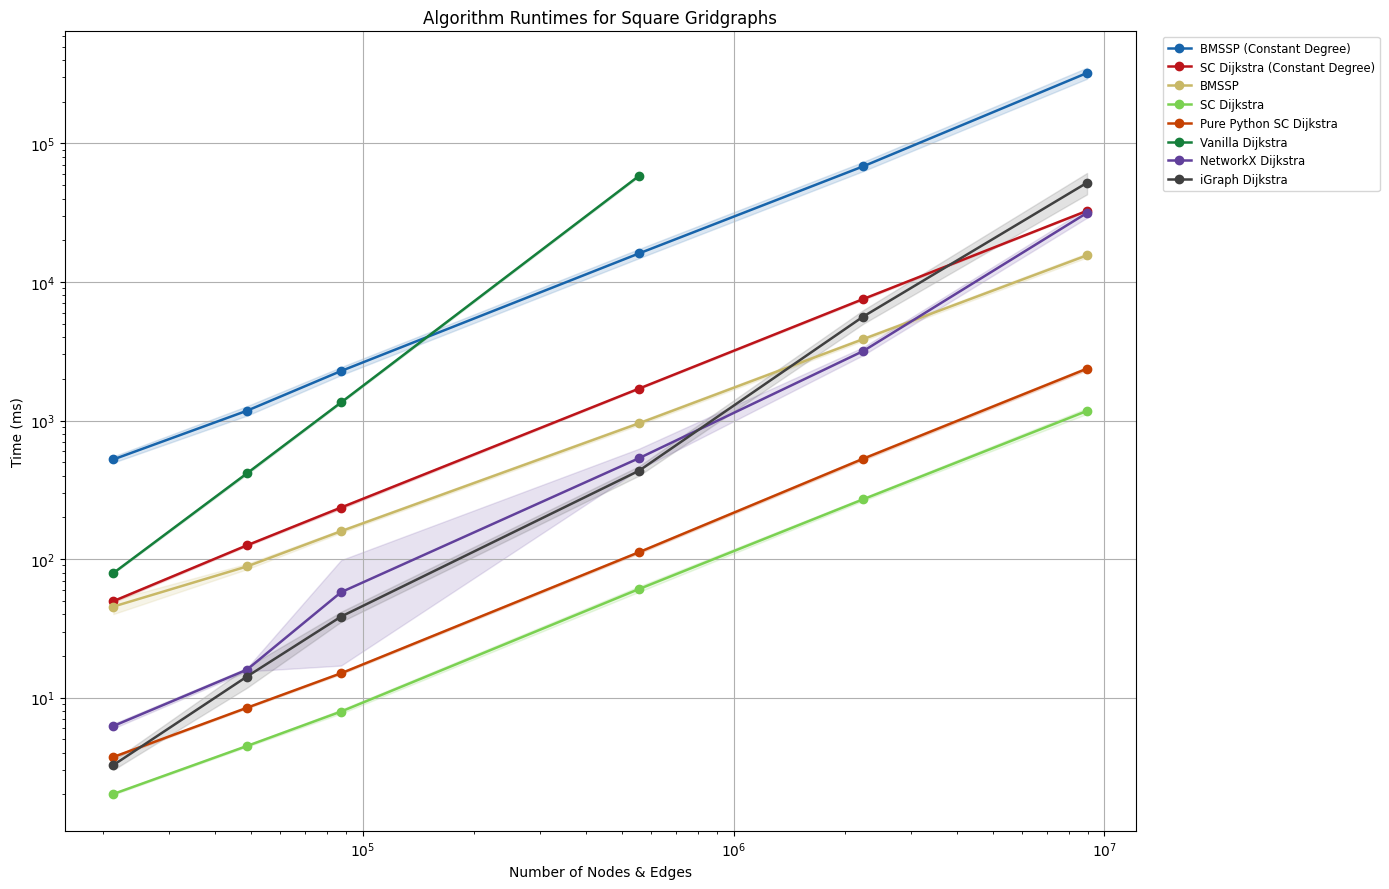

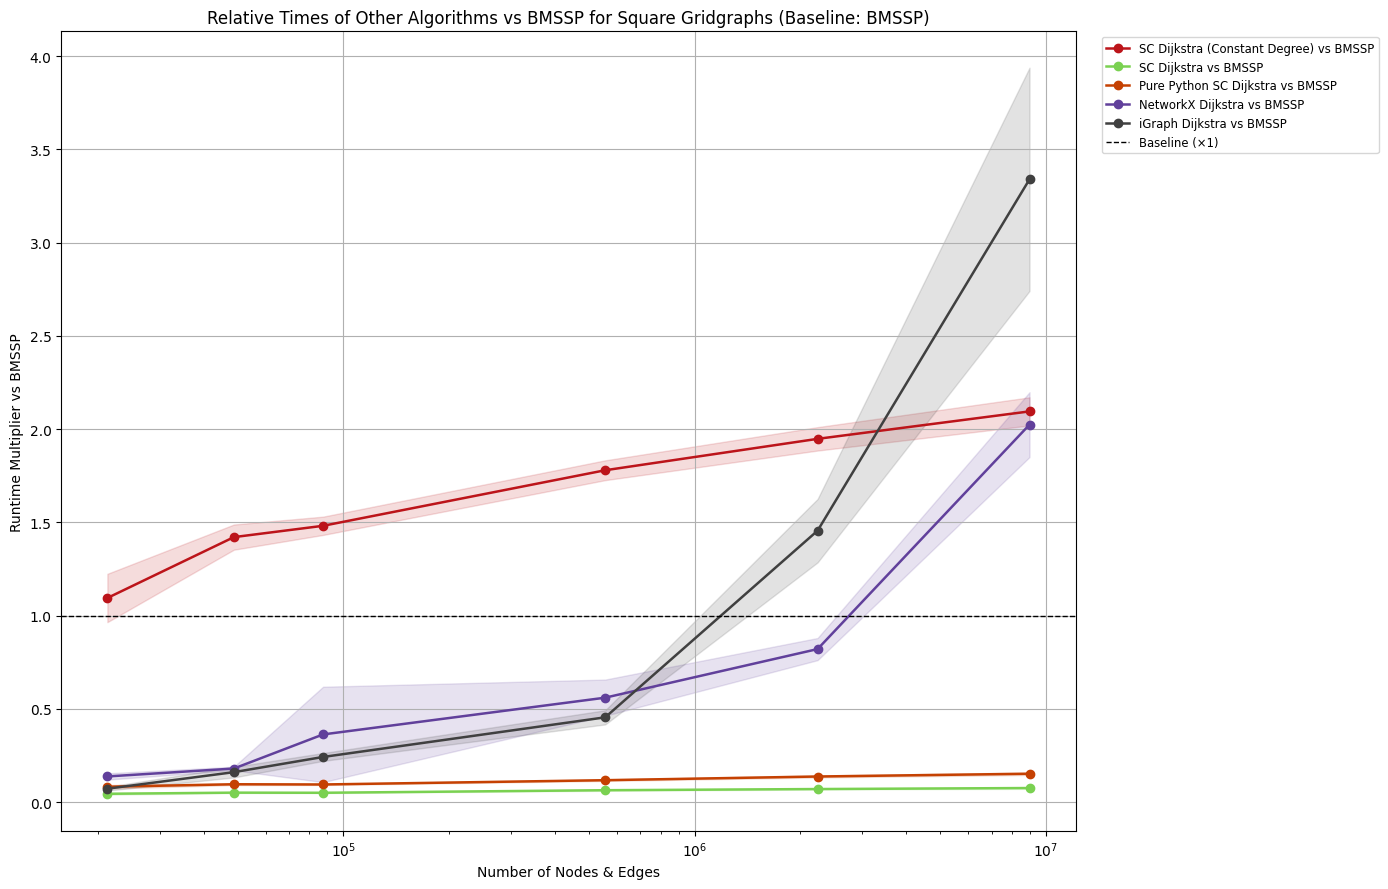

In [8]:
square_grid_data = [i for i in data if 'Square' in i['graph_name']]

make_aggregated_graph(
    square_grid_data, 
    "Algorithm Runtimes for Square Gridgraphs", 
    scale="log",
)
make_relative_performance_graph(
    square_grid_data, 
    "Relative Times of Other Algorithms vs BMSSP for Square Gridgraphs (Baseline: BMSSP)", 
    baseline_alg="bmssp_solve_time_ms", 
    scale="log", 
    algorithms=algorithms_faster
)

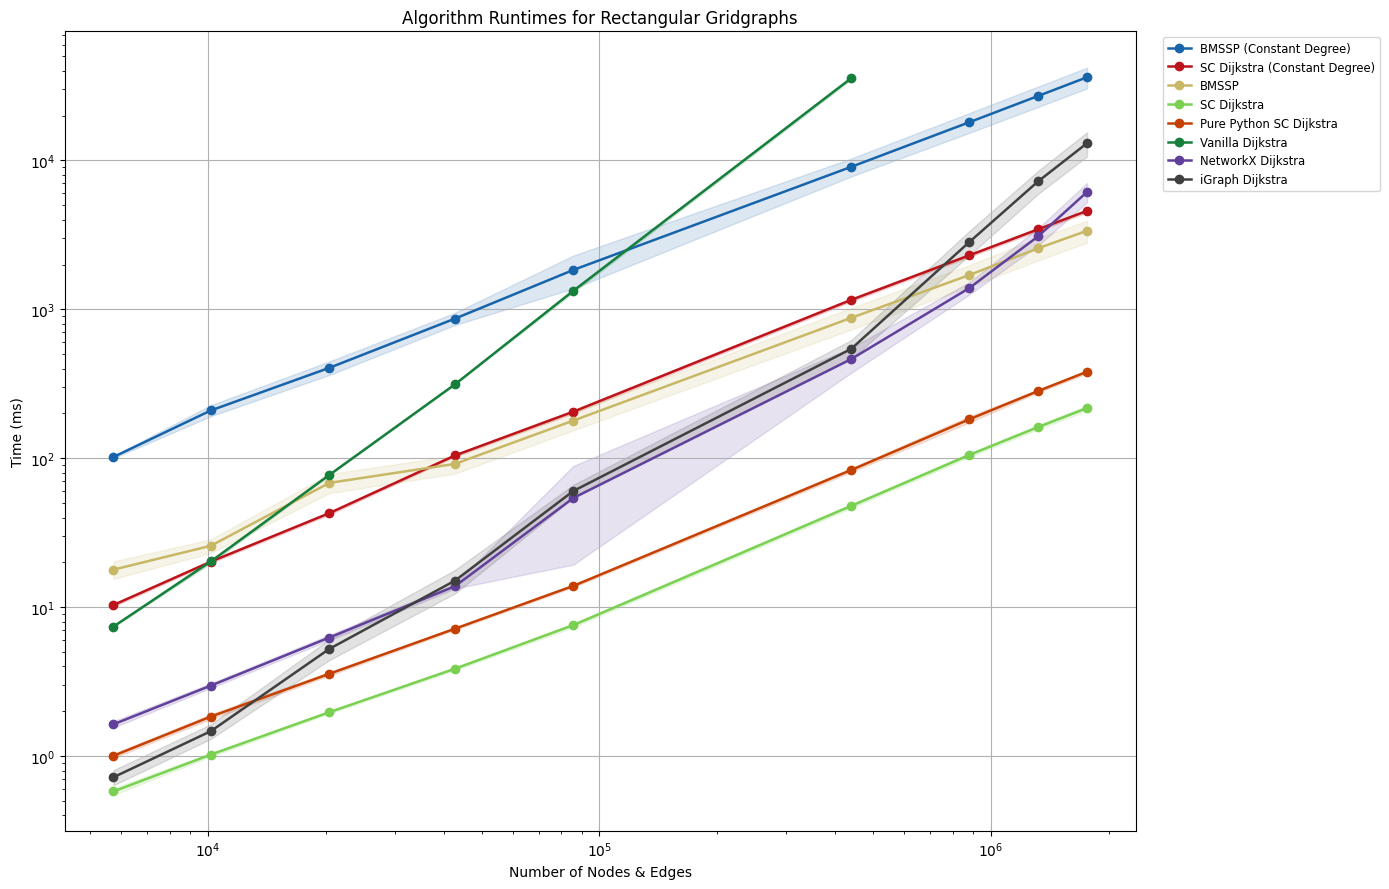

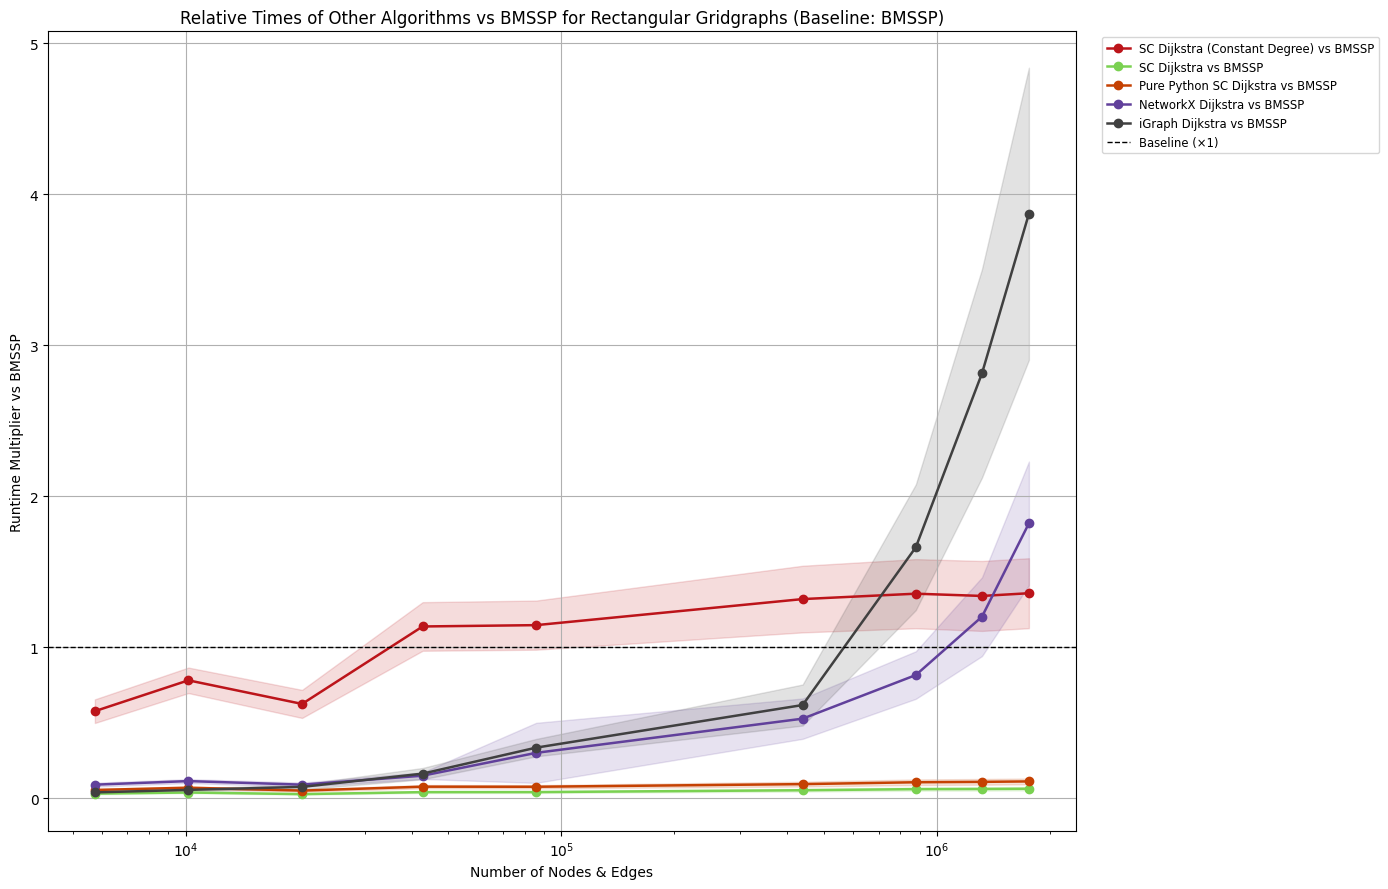

In [9]:
rectangular_grid_data = [i for i in data if 'Rectangular' in i['graph_name']]
make_aggregated_graph(rectangular_grid_data, "Algorithm Runtimes for Rectangular Gridgraphs", scale="log")
make_relative_performance_graph(rectangular_grid_data, "Relative Times of Other Algorithms vs BMSSP for Rectangular Gridgraphs (Baseline: BMSSP)", baseline_alg="bmssp_solve_time_ms", scale="log", algorithms=algorithms_faster)

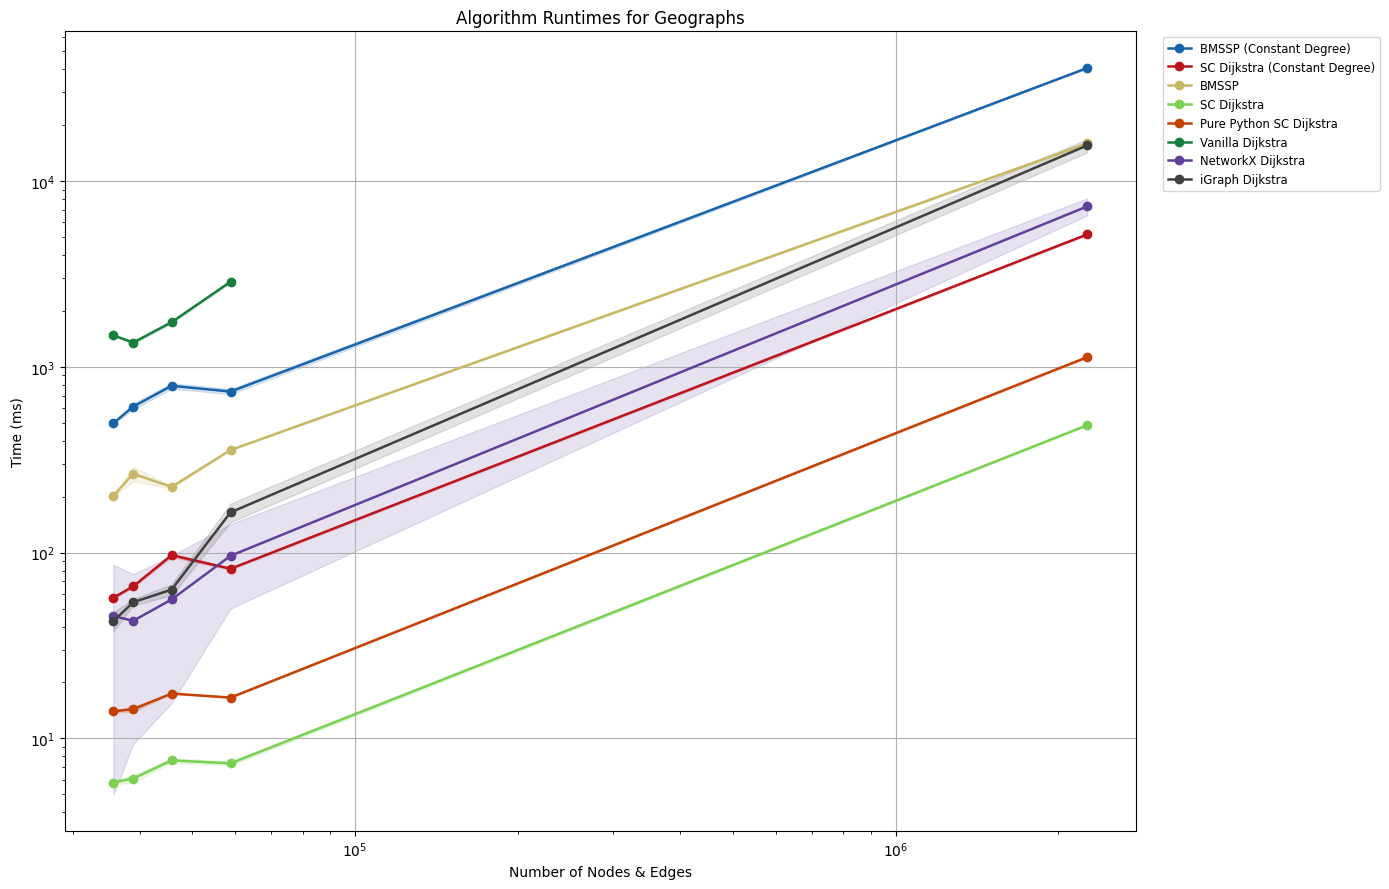

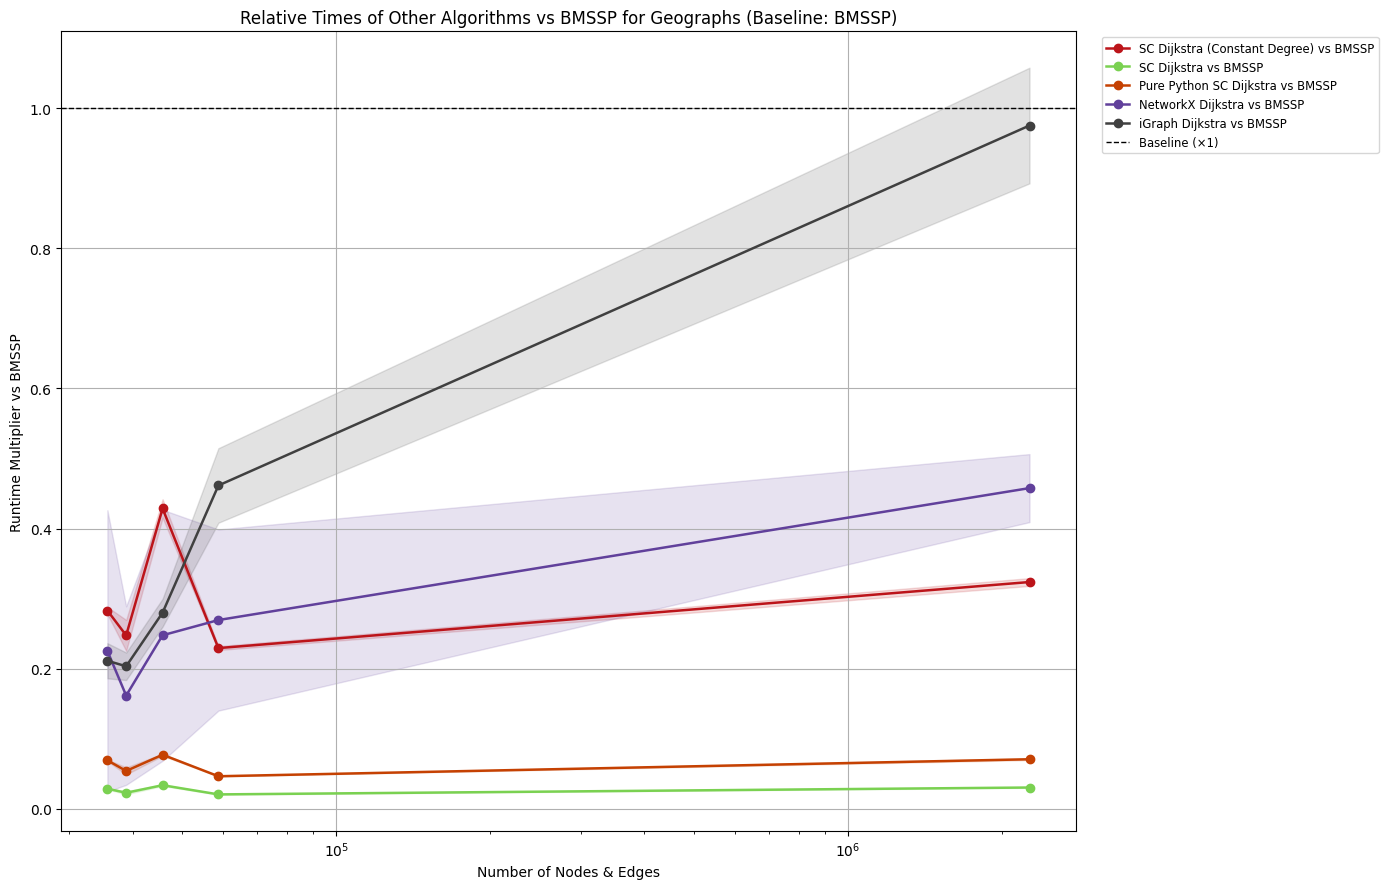

In [10]:
geograph_data = [i for i in data if 'Geograph' in i['graph_name']]

make_aggregated_graph(geograph_data, "Algorithm Runtimes for Geographs", scale="log")

# Omit the Vanilla Dijkstra for more clarity
no_vd = {k:v for k, v in algorithms.items() if k != "vanilla_dijkstra_time_ms"}
make_relative_performance_graph(geograph_data, "Relative Times of Other Algorithms vs BMSSP for Geographs (Baseline: BMSSP)", baseline_alg="bmssp_solve_time_ms", scale="log", algorithms=algorithms_faster)

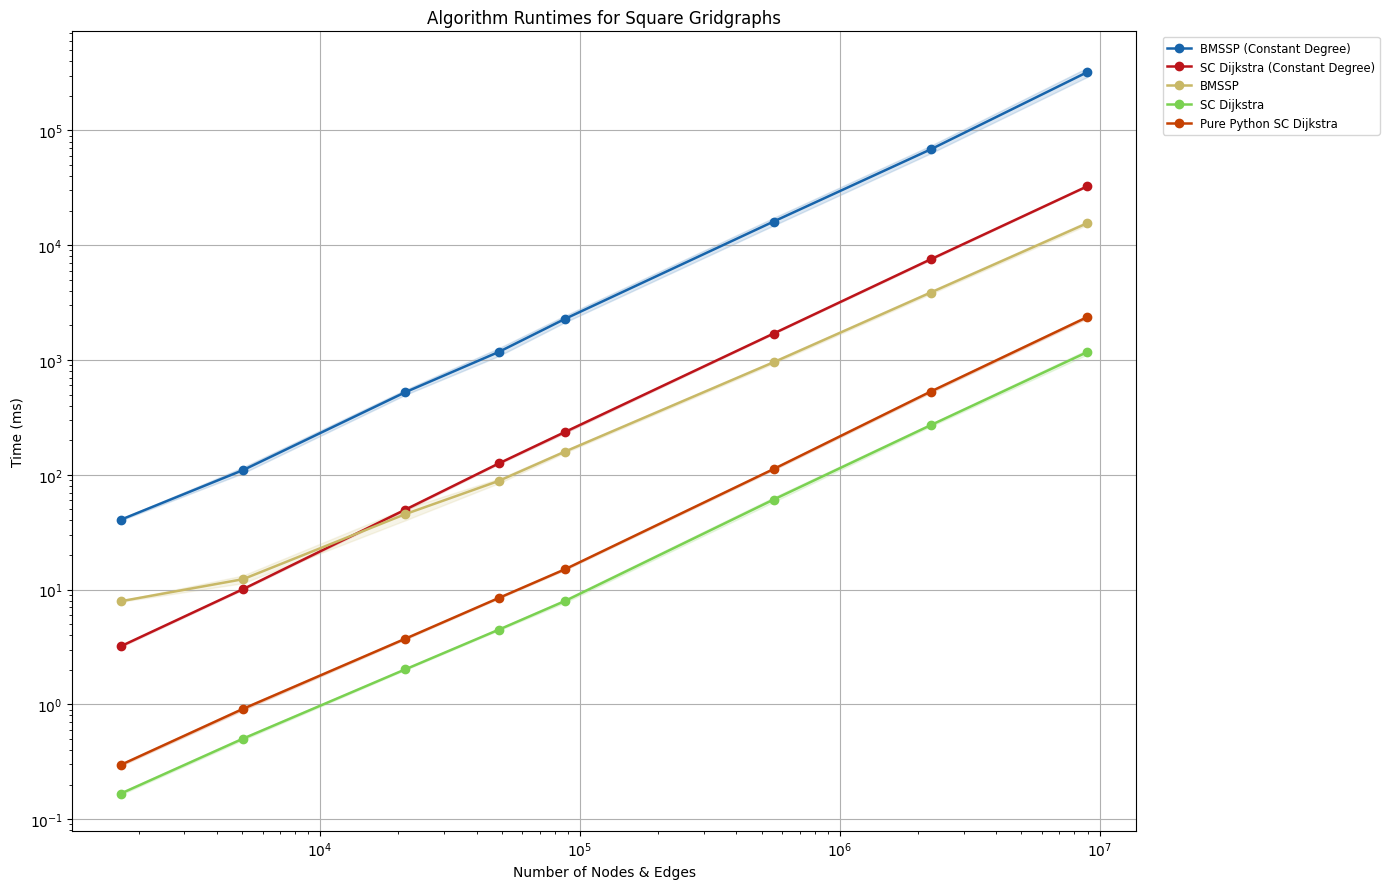

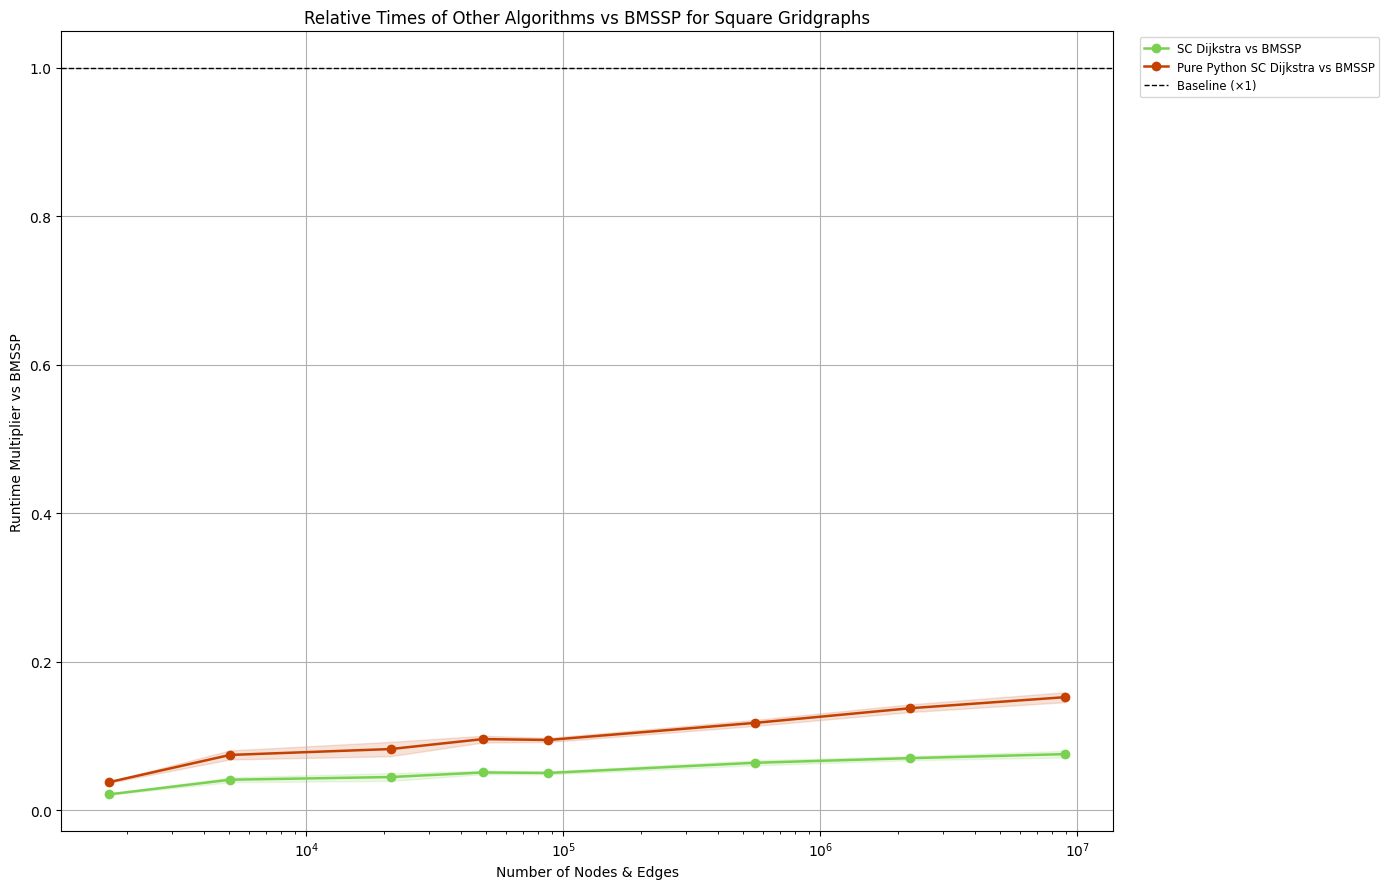

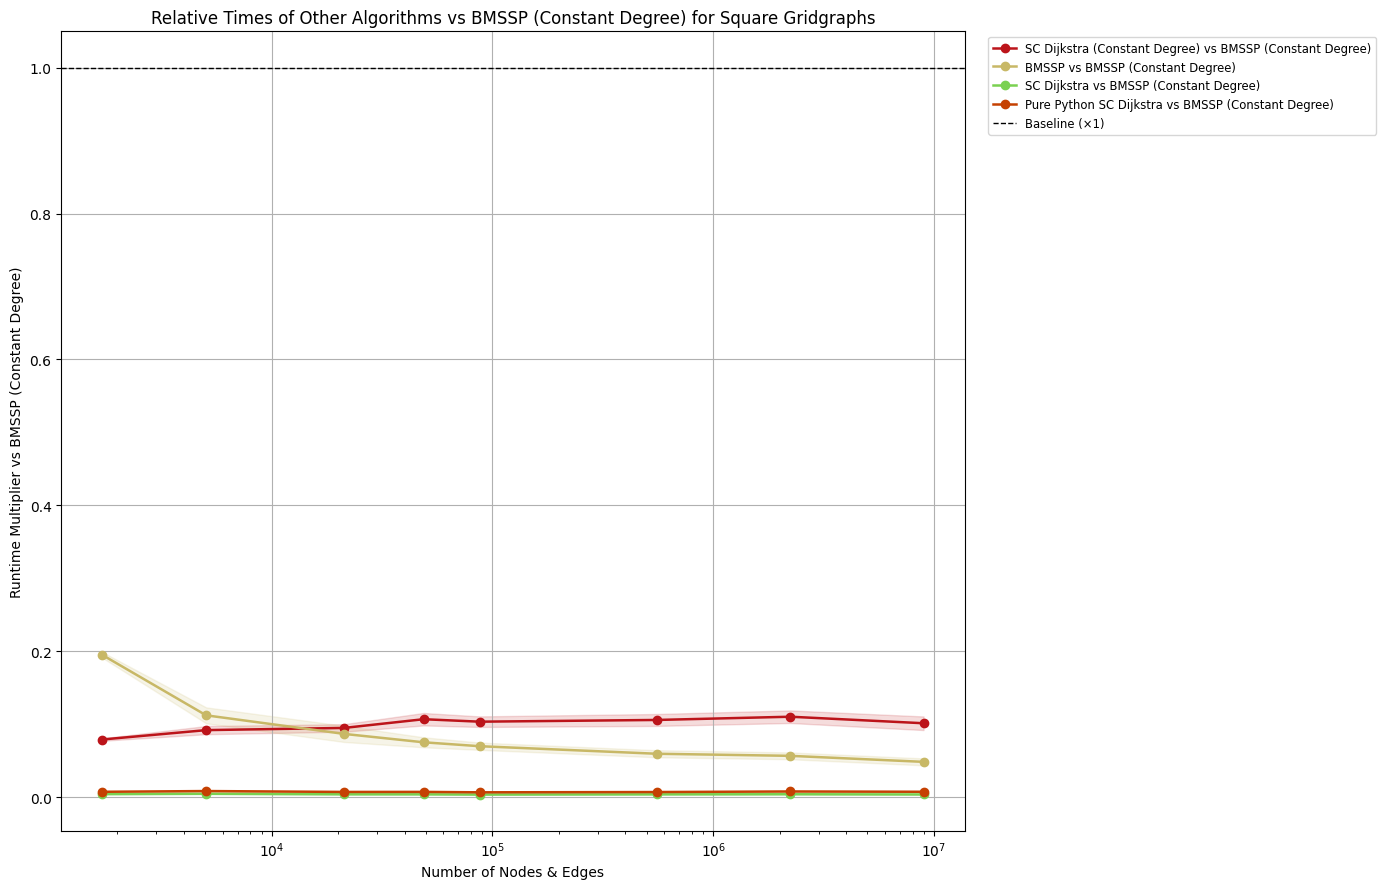

In [11]:
make_aggregated_graph(gridscale_data, "Algorithm Runtimes for Square Gridgraphs", scale="log", algorithms=algorithms_gridscale)
make_relative_performance_graph(gridscale_data, "Relative Times of Other Algorithms vs BMSSP for Square Gridgraphs", baseline_alg="bmssp_solve_time_ms", scale="log", algorithms=algorithms_gridscale_no_constant_degree)
make_relative_performance_graph(gridscale_data, "Relative Times of Other Algorithms vs BMSSP (Constant Degree) for Square Gridgraphs", baseline_alg="bmssp_constant_degree_solve_time_ms", scale="log", algorithms=algorithms_gridscale)

[1709, 1709, 1709, 5049, 5049, 5049, 21274, 21274, 21274, 48749, 48749, 48749, 87474, 87474, 87474, 556074, 556074, 556074, 2237074, 2237074, 2237074, 8974074, 8974074, 8974074] [41.50354862213135, 39.0392541885376, 41.175055503845215, 120.40319442749023, 94.10557746887207, 114.71827030181885, 570.4732656478882, 460.6187343597412, 540.2127981185913, 1283.3654403686523, 1064.6102666854858, 1181.087040901184, 2536.9478464126587, 1939.5976781845093, 2355.5249452590942, 18247.310519218445, 13184.93390083313, 16779.02708053589, 77087.4755859375, 55815.296602249146, 72153.62627506256, 375109.15496349335, 252867.01946258545, 338960.47983169556] [3.3134937286376953, 3.1413793563842773, 3.1603097915649414, 10.294008255004883, 9.800243377685547, 10.149335861206055, 50.18637180328369, 47.727012634277344, 51.15365982055664, 129.30355072021484, 122.26994037628174, 125.35624504089354, 241.07108116149902, 223.57072830200195, 241.96224212646484, 1708.1930875778198, 1664.4394397735596, 1727.84082889556

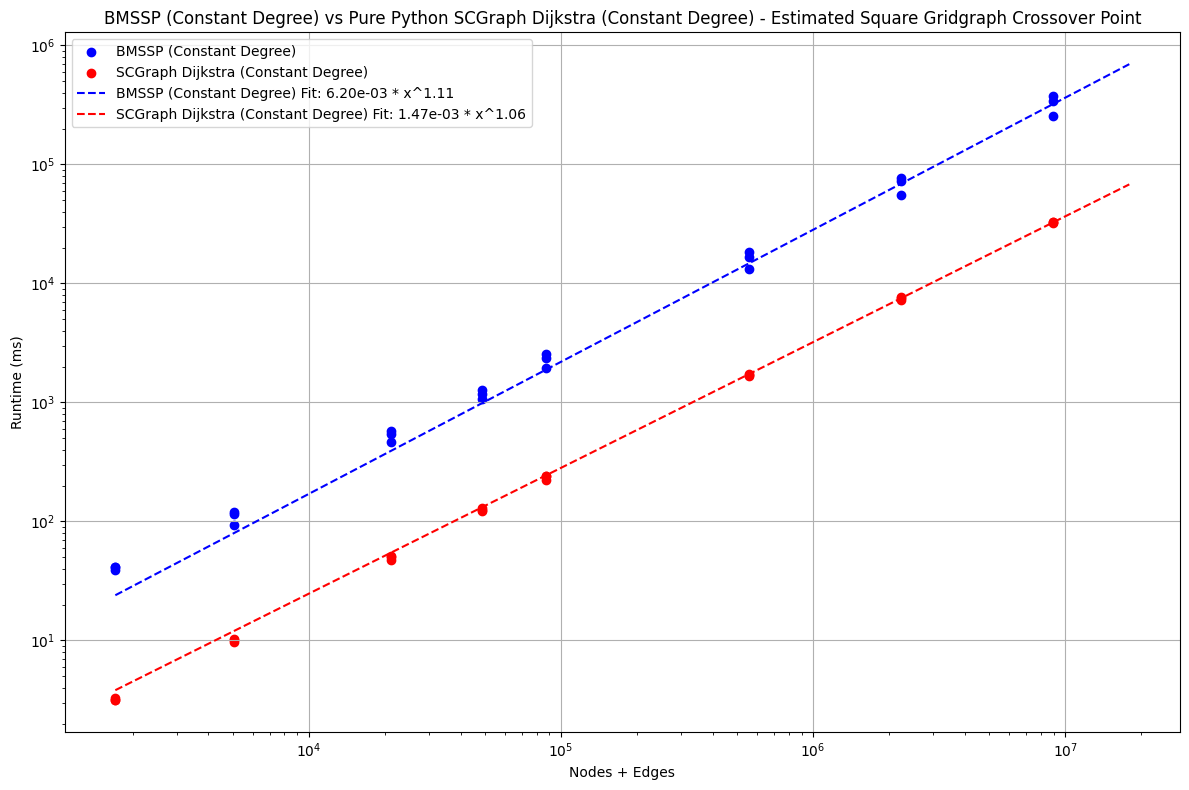

In [12]:
x_vals = [i['graph_nodes']+i['graph_edges'] for i in gridscale_data if i['bmssp_constant_degree_solve_time_ms']!='nan']
y_bmssp = [i["bmssp_constant_degree_solve_time_ms"] for i in gridscale_data if i['bmssp_constant_degree_solve_time_ms']!='nan']
y_purepy = [i["pure_python_sc_dijkstra_constant_degree_time_ms"] for i in gridscale_data if i['pure_python_sc_dijkstra_constant_degree_time_ms']!='nan']

print(x_vals, y_bmssp, y_purepy)

a1, b1 = fit_curve(x_vals, y_bmssp)
a2, b2 = fit_curve(x_vals, y_purepy)
x_crossover = find_crossover(a1, b1, a2, b2)

plot_with_crossover(x_vals, y_bmssp, y_purepy, a1, b1, a2, b2, x_crossover,
    algo_1_name="BMSSP (Constant Degree)",
    algo_2_name="SCGraph Dijkstra (Constant Degree)",
    title="BMSSP (Constant Degree) vs Pure Python SCGraph Dijkstra (Constant Degree) - Estimated Square Gridgraph Crossover Point",
    scale="log",
)

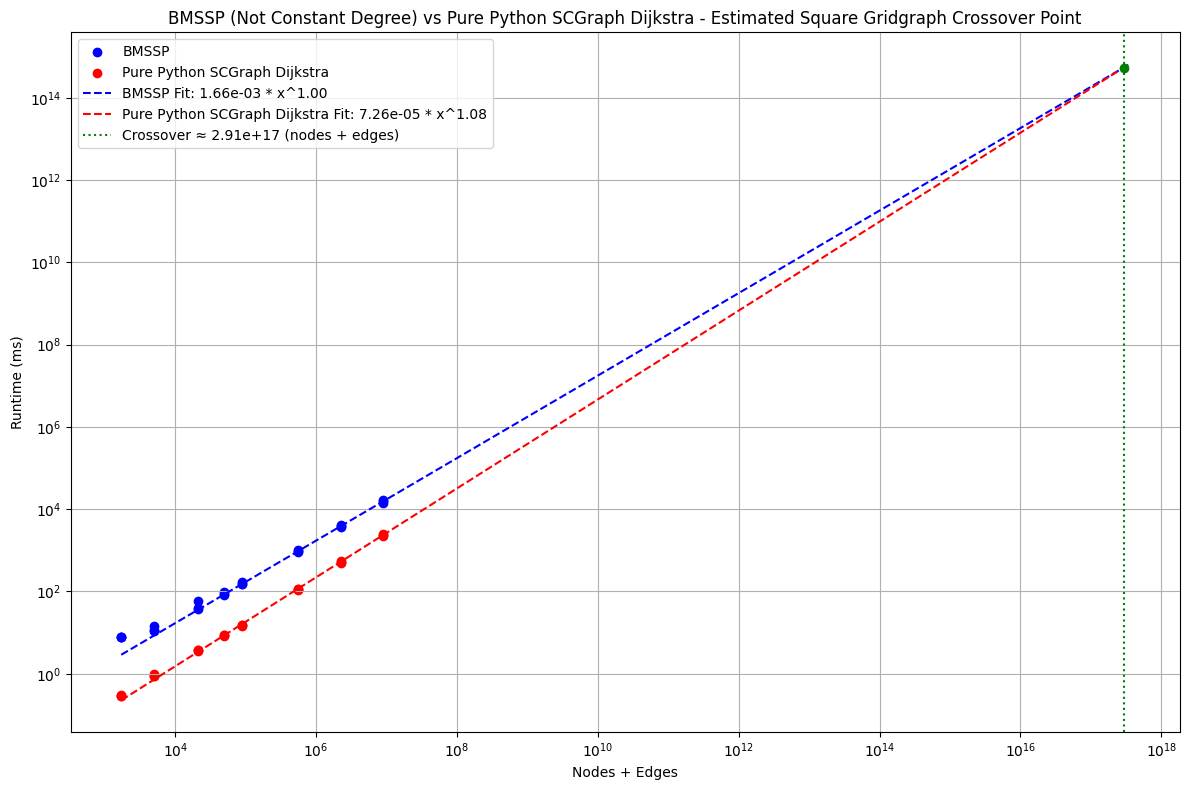

In [13]:
x_vals = [i['graph_nodes']+i['graph_edges'] for i in gridscale_data]
y_bmssp = [i["bmssp_solve_time_ms"] for i in gridscale_data]
y_purepy = [i["pure_python_sc_dijkstra_time_ms"] for i in gridscale_data]

a1, b1 = fit_curve(x_vals, y_bmssp)
a2, b2 = fit_curve(x_vals, y_purepy)
x_crossover = find_crossover(a1, b1, a2, b2)

plot_with_crossover(x_vals, y_bmssp, y_purepy, a1, b1, a2, b2, x_crossover,
    algo_1_name="BMSSP",
    algo_2_name="Pure Python SCGraph Dijkstra",
    title="BMSSP (Not Constant Degree) vs Pure Python SCGraph Dijkstra - Estimated Square Gridgraph Crossover Point",
    scale="log",
)